In [86]:
import requests

def download_file(url, target_path):
  try:
    response = requests.get(url)
    response.raise_for_status()
    with open(target_path, "wb")as f:
      f.write(response.content)
    print(f"Downloaded file {target_path}")
  except requests.exceptions.RequestException as e:
    print(f"Failed to Download {url}. Error: {e}")

files_to_download = [
    ('https://raw.githubusercontent.com/galeajua/coffee-brewer/master/data/arabica_raw.csv', 'arabica_raw.csv'),
    ('https://raw.githubusercontent.com/galeajua/coffee-brewer/master/data/cotter_raw.csv', 'cotter_raw.csv')
]

for url, path in files_to_download:
  download_file(url, path)


Downloaded file arabica_raw.csv
Downloaded file cotter_raw.csv


In [87]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway


In [88]:
# Load Data
arabica_data = pd.read_csv('arabica_raw.csv')
cotter_data = pd.read_csv('cotter_raw.csv')

In [89]:
# Basic Info
print("Arabica Dataset:")
arabica_data.info()
print("\nCotter Dataset:")
cotter_data.info()

Arabica Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        1312 non-null   int64  
 1   quality_score                     1312 non-null   float64
 2   view_certificate_1                0 non-null      float64
 3   view_certificate_2                0 non-null      float64
 4   Cupping Protocol and Descriptors  0 non-null      float64
 5   View Green Analysis Details       0 non-null      float64
 6   Request a Sample                  0 non-null      float64
 7   Species                           1312 non-null   object 
 8   Owner                             1305 non-null   object 
 9   Country of Origin                 1311 non-null   object 
 10  Farm Name                         956 non-null    object 
 11  Lot Number                        270 non-null    ob

In [90]:
# Sizes
print(f"The Arabica Dataset has a length of {len(arabica_data)} and a shape of {arabica_data.shape}")
print(f"The Cotter Dataset has a length of {len(cotter_data)} and a shape of {cotter_data.shape}")

The Arabica Dataset has a length of 1312 and a shape of (1312, 53)
The Cotter Dataset has a length of 3186 and a shape of (3186, 48)


In [91]:
# Einblick in die ersten paar Zeilen beider Datensätze
pd.set_option("display.max.columns", None)
print("\nArabica Dataset:\n")
print(arabica_data.head())
print("\n")
print("\n")
print("\nCotter Dataset:\n")
print("\n")
print("\n")
print(cotter_data.head())


Arabica Dataset:

   Unnamed: 0  quality_score  view_certificate_1  view_certificate_2  \
0           0          90.58                 NaN                 NaN   
1           1          89.92                 NaN                 NaN   
2           2          89.75                 NaN                 NaN   
3           3          89.00                 NaN                 NaN   
4           4          88.83                 NaN                 NaN   

   Cupping Protocol and Descriptors  View Green Analysis Details  \
0                               NaN                          NaN   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          NaN   
4                               NaN                          NaN   

   Request a Sample  Species                     Owner Country of Origin  \
0               NaN  Arabica                 metad plc         


Arabica Dataset Summary Statistics:

        Unnamed: 0  quality_score  view_certificate_1  view_certificate_2  \
count  1312.000000    1312.000000                 0.0                 0.0   
mean    655.309451      82.086212                 NaN                 NaN   
std     378.860186       3.675542                 NaN                 NaN   
min       0.000000       0.000000                 NaN                 NaN   
25%     327.750000      81.170000                 NaN                 NaN   
50%     655.500000      82.500000                 NaN                 NaN   
75%     983.250000      83.670000                 NaN                 NaN   
max    1310.000000      90.580000                 NaN                 NaN   

       Cupping Protocol and Descriptors  View Green Analysis Details  \
count                               0.0                          0.0   
mean                                NaN                          NaN   
std                                 NaN             

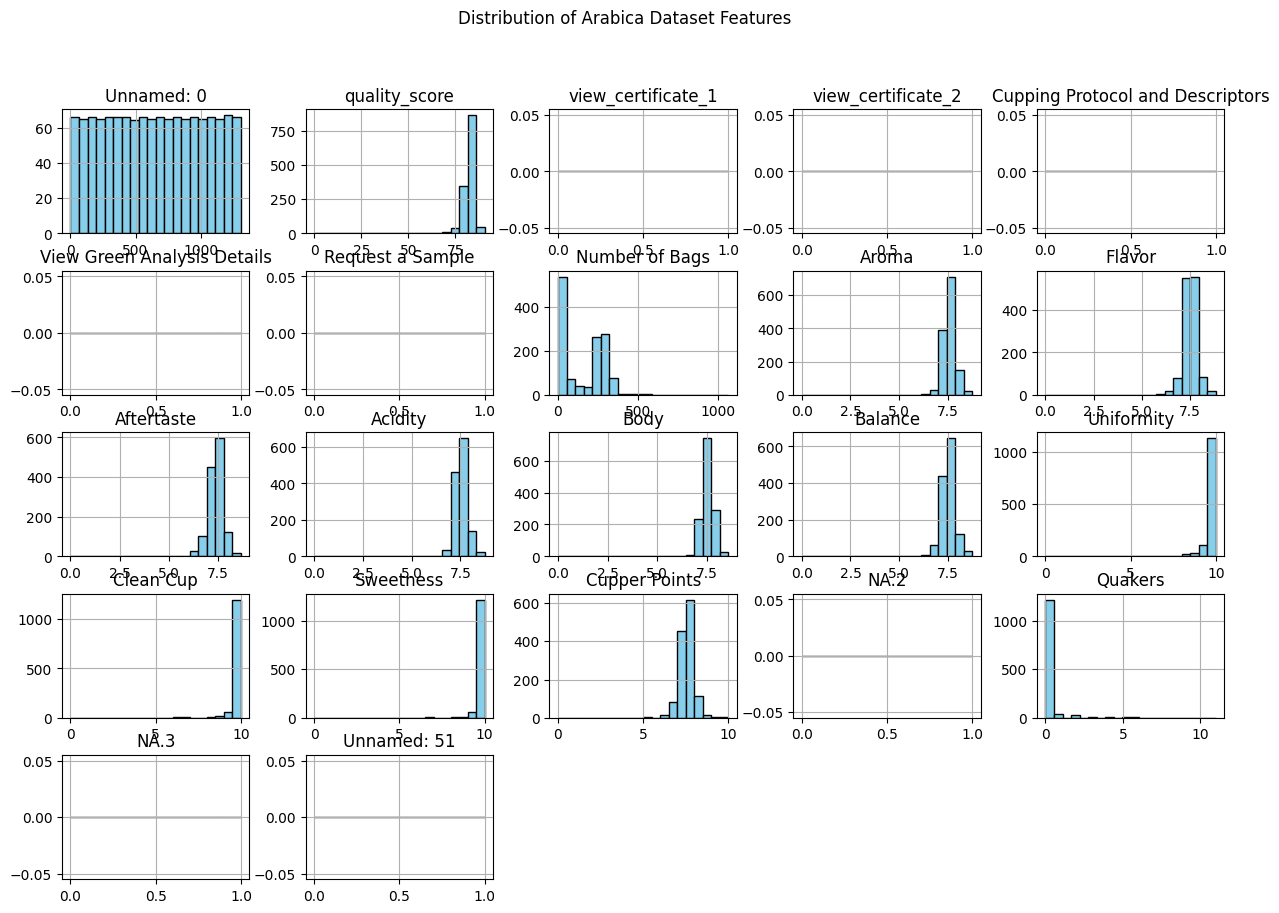

In [92]:
# Summary & Missing Values Arabica
print("\nArabica Dataset Summary Statistics:\n")
print(arabica_data.describe())
print("\nMissing Values in Arabica Dataset:\n")
print(arabica_data.isnull().sum())

# Distribution Arabica
arabica_data.hist(figsize=(15, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Arabica Dataset Features")
plt.show()

In [93]:
# Um sinnvolle Hypothesentest und beispielsweise Heatmaps darstellen zu können, müssen wir den Arabica-Datensatz ein erstes Mal
# bereinigen.

# Verwerfung von Spalten die wir sicher nicht verwenden werden (aufgrund von bspw. laueter null-values)
drop_columns_arabica = ['Unnamed: 0', 'view_certificate_1', 'view_certificate_2',
                   'Cupping Protocol and Descriptors', 'View Green Analysis Details',
                   'Request a Sample', 'Lot Number', 'Mill', 'ICO Number',
                   'Number of Bags', 'Bag Weight', 'In-Country Partner',
                   'Status', 'NA', 'NA.1', 'NA.2', 'Category One Defects',
                   'Quakers', 'Category Two Defects', 'NA.3', 'Expiration',
                   'Certification Body', 'Certification Address', 'Certification Contact',
                   'Unnamed: 51', 'Notes', 'Owner', 'Owner.1', 'Region', 'Producer',
                   'Company', 'Farm Name', 'Harvest Year', 'Grading Date']

arabica_data = arabica_data.drop(columns=drop_columns_arabica)

In [94]:
print(arabica_data['Altitude'])


0           1950-2200
1           1950-2200
2       1600 - 1800 m
3           1800-2200
4           1950-2200
            ...      
1307            ~350m
1308             1100
1309             4650
1310             TEST
1311             1400
Name: Altitude, Length: 1312, dtype: object


In [95]:
# um die Spalte 'Altitude' nutzen zu können, müssen wir die Werte standardisieren. Dazu werden wir jeweils den numerischen Wert extrahieren
# (in Meter) und setzen bei zwei Werten (Ober- und Untergrenze) den Durchschnitt beider Werte
def extract_numeric_values(value):

    if pd.isnull(value):
        return None
    
    numbers = re.findall(r'[-+]?\d*\.\d+|\d+', value)
    numbers = list(map(float, numbers))

    if len(numbers) == 1:
        altitude = numbers[0]
    elif len(numbers) == 2:
        altitude = sum(numbers) / 2
    else:
        return None
    
    if altitude < 10:
        altitude *= 1000

    return round(altitude, 2)


arabica_data['Altitude'] = arabica_data['Altitude'].apply(extract_numeric_values)


In [98]:
# Um Situationen zu handhaben, in denen bspw. Interpunktion verwendet wird, um Kilometer statt Meter auszudrücken,
# setzen wir einen Threshold und multiplizieren wir * 1000 falls dieser überschritten wird
arabica_data['Altitude'] = arabica_data['Altitude'].apply(lambda x: x * 1000 if x < 10 else x)
arabica_data.rename(columns={'Altitude': 'Altitude (m)', 'quality_score': 'score'}, inplace=True)

In [99]:
# handhabung der Spalten 'Total Cup Points' und 'Moisture'
arabica_data['Total Cup Points'] = arabica_data['Total Cup Points'].str.extract(r'(\d+\.\d+)')

# verwandle bspw. den Wert '12 %' zu 0.12
arabica_data['Moisture'] = arabica_data['Moisture'].str.replace('%', '').astype(float) / 100
arabica_data.rename(columns={'Moisture': 'Moisture (%)'}, inplace=True)


Cotter Dataset Summary Statistics:
            Judge      Cluster         Week  Session Number     Position  \
count  3186.00000  3186.000000  3186.000000     3186.000000  3186.000000   
mean     59.50000     1.567797     2.074074        9.693346     5.351852   
std      34.06779     0.495460     0.813257        5.064340     2.799561   
min       1.00000     1.000000     1.000000        1.000000     1.000000   
25%      30.00000     1.000000     1.000000        5.000000     3.000000   
50%      59.50000     2.000000     2.000000       10.000000     5.000000   
75%      89.00000     2.000000     3.000000       14.000000     8.000000   
max     118.00000     2.000000     3.000000       18.000000    10.000000   

              Dose        Grind  Empty Carafe  Full Carafe    Brew Mass  \
count  3186.000000  3186.000000   3186.000000  3186.000000  3186.000000   
mean    180.125926     3.740741   1783.430854  4609.905085  2826.474231   
std      39.226754     0.926812     12.023245    49.54

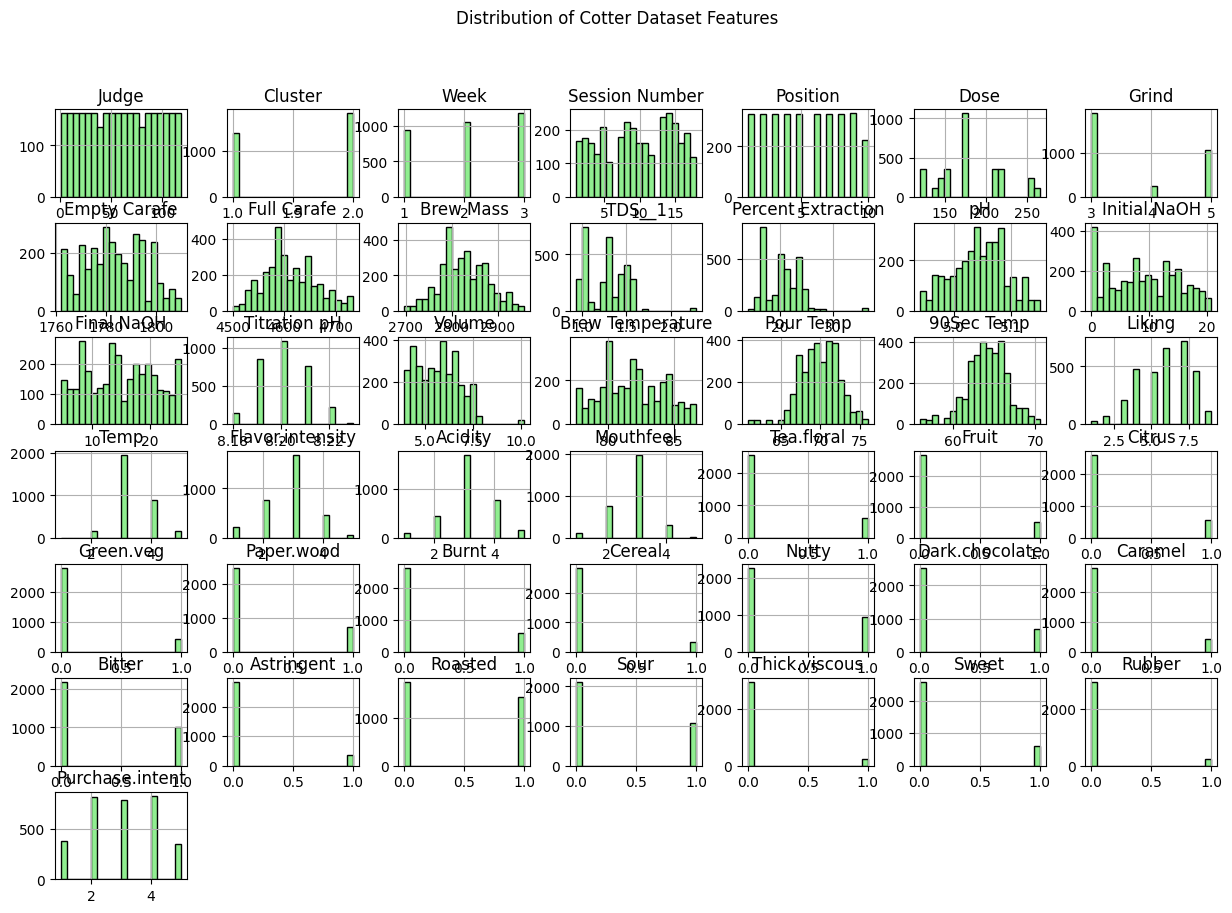

In [100]:
# Summary & Missing Values Cotter
print("\nCotter Dataset Summary Statistics:")
print(cotter_data.describe())
print("\nMissing Values in Cotter Dataset:")
print(cotter_data.isnull().sum())

# Distribution Cotter
cotter_data.hist(figsize=(15, 10), bins=20, color='lightgreen', edgecolor='black')
plt.suptitle("Distribution of Cotter Dataset Features")
plt.show()

In [101]:
# der Cotter-Datensatz braucht weniger initiale Bereinigung als der Arabica-Datensatz

# Verwerfung von Spalten die wir sicher nicht verwenden werden
drop_columns_cotter = ['Judge', 'Cluster', 'Week', 'Session Number', 'Position', 
                          'Empty Carafe', 'Full Carafe', 'Initial NaOH', 'Final NaOH',
                          'Titration pH', 'Volume', 'Brew Temperature', 'Pour Temp',
                          '90Sec Temp', 'Purchase.intent', 'Temp.x', 'TDS.x', 'PE.x']

cotter_data = cotter_data.drop(columns=drop_columns_cotter)

In [102]:
# Wir extrahieren die numerischen Werte der 'Brew'-Spalte und kreieren neue Spalten daraus
# Extract values using regex
cotter_data[['target_brew_temperature', 'target_total_dissolved_solids', 'target_extraction (%)']] = cotter_data['Brew'].str.extract(r"(\d+)\s*-\s*(\d+\.\d+)\s*-\s*(\d+)")

# Convert extracted columns to appropriate data types
cotter_data['target_brew_temperature'] = cotter_data['target_brew_temperature'].astype('int16')
cotter_data['target_total_dissolved_solids'] = cotter_data['target_total_dissolved_solids'].astype('float32')
cotter_data['target_extraction (%)'] = cotter_data['target_extraction (%)'].astype('int16')
cotter_data.drop(columns=['Brew'], inplace=True)
print(cotter_data.describe())

KeyError: 'Brew'

In [ ]:
# Wir geben den Spalten zutreffendere Namen
cotter_data.rename(columns={'Brew Mass': 'Brew_Mass (g)',
                            'TDS__1': 'total_dissolved_solids',
                            'Percent Extraction': 'extraction (%)'}, inplace=True)



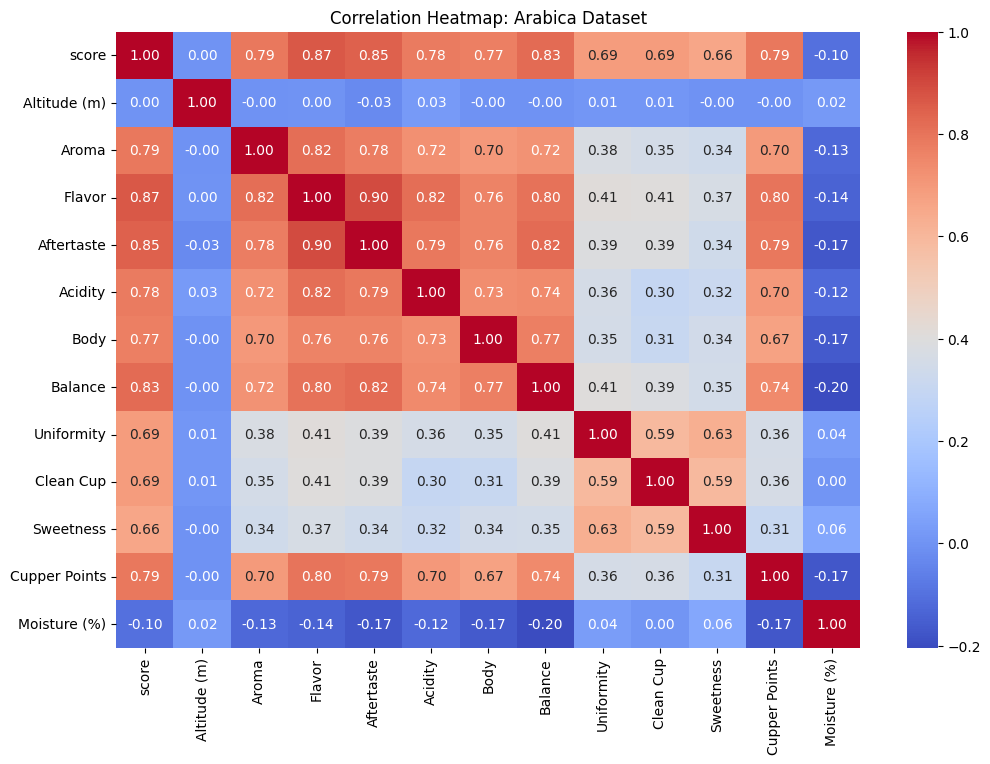

In [ ]:
## Relationships and Groups
#Correlation Analysis Arabica
plt.figure(figsize=(12, 8))
numeric_columns_arabica = arabica_data.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_columns_arabica.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Arabica Dataset")
plt.show()

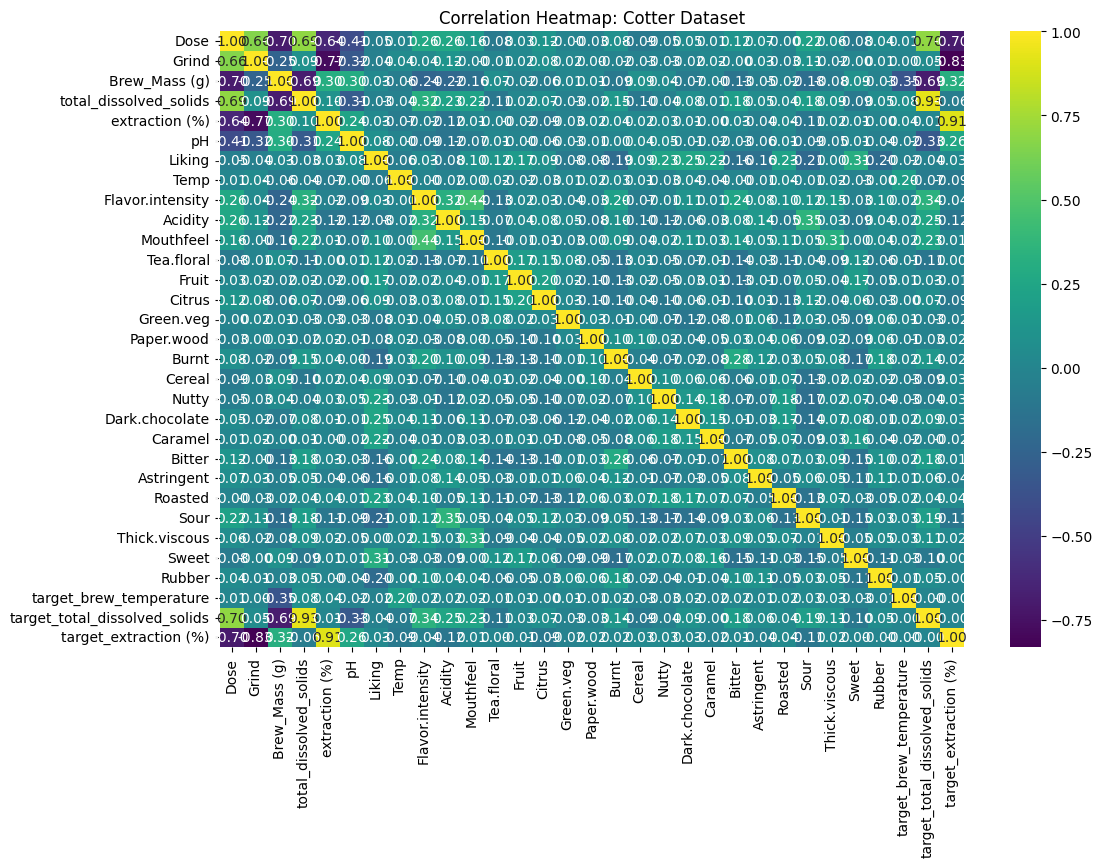

In [ ]:
# Correlation analysis for Cotter dataset
plt.figure(figsize=(12, 8))
numeric_columns_cotter = cotter_data.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_columns_cotter.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap: Cotter Dataset")
plt.show()

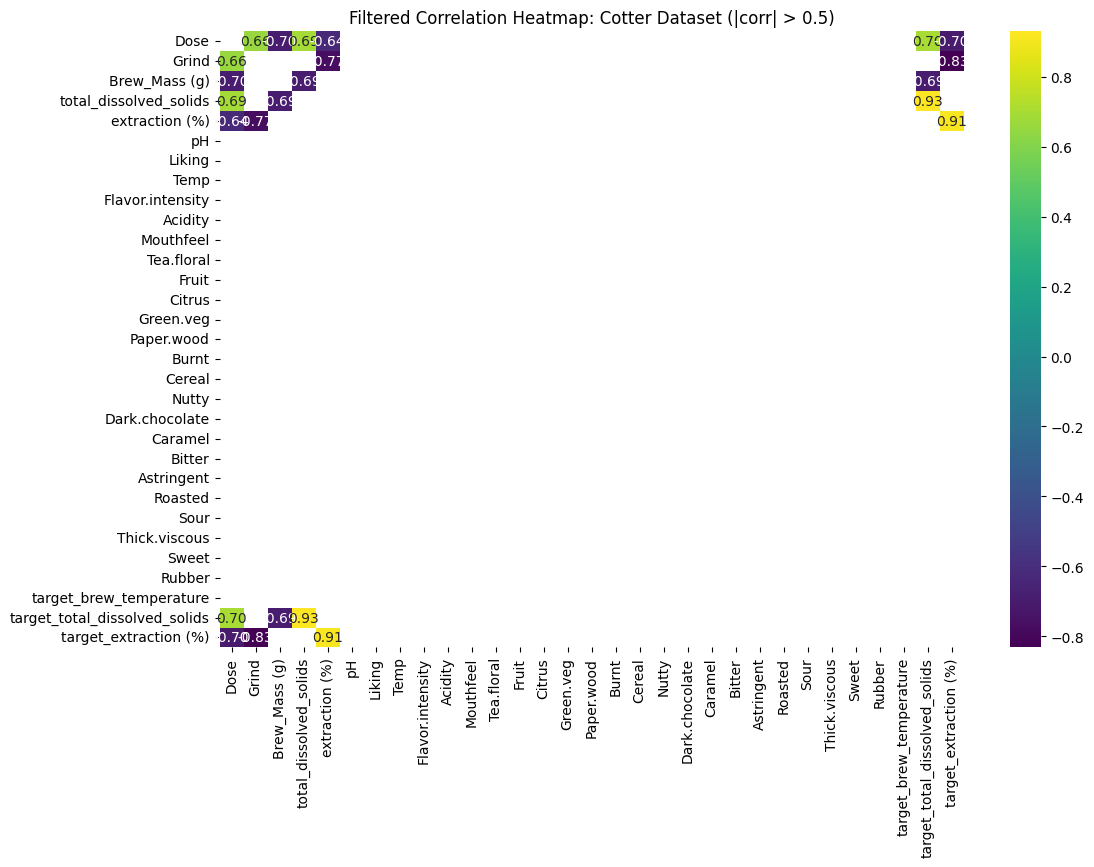

In [ ]:
# Due to the Cotter Dataset being so large and a full correlation matrix not being fully readable we'll filter the matrix to the more significant correlations
numeric_columns_cotter = cotter_data.select_dtypes(include=['float64', 'int64'])
corr_matrix_cotter = numeric_columns_cotter.corr()

# Filter correlations with absolute value > 0.5
filtered_corr = corr_matrix_cotter[(corr_matrix_cotter.abs() > 0.5) & (corr_matrix_cotter != 1.0)]

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, annot=True, cmap='viridis', fmt=".2f", mask=filtered_corr.isnull())
plt.title("Filtered Correlation Heatmap: Cotter Dataset (|corr| > 0.5)")
plt.show()


                              average_score  entry_count
Country of Origin                                       
United States                     85.978750            8
Papua New Guinea                  85.750000            1
Japan                             84.670000            1
Ethiopia                          84.542889           45
Kenya                             84.309600           25
Uganda                            84.051923           26
Ecuador                           83.830000            1
Panama                            83.707500            4
Colombia                          83.106557          183
El Salvador                       83.052857           21
China                             82.927500           16
Rwanda                            82.830000            1
Costa Rica                        82.789020           51
Thailand                          82.573750           32
Indonesia                         82.565500           20
Peru                           

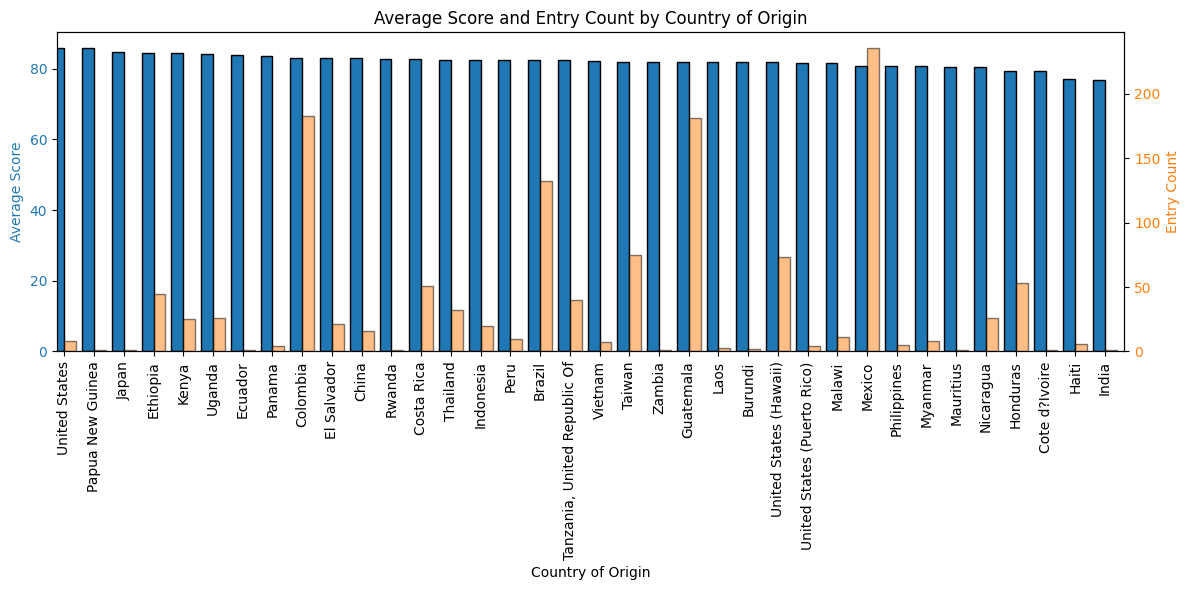

In [ ]:
# Group analysis Arabica
country_groups = arabica_data.groupby('Country of Origin').agg(
    average_score=('score', 'mean'),
    entry_count=('score', 'count')
).sort_values(by='average_score', ascending=False)

print(country_groups)

fig, ax1 = plt.subplots(figsize=(12, 6))

# plot average scores
color = 'tab:blue'
ax1.set_title("Average Score and Entry Count by Country of Origin")
ax1.set_xlabel("Country of Origin")
ax1.set_ylabel("Average Score", color=color)
country_groups['average_score'].plot(kind='bar', ax=ax1, color=color, edgecolor='black', position=1, width=0.4)
ax1.tick_params(axis='y', labelcolor=color)

# plot number of data points on the secondary axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel("Entry Count", color=color)
country_groups['entry_count'].plot(kind='bar', ax=ax2, color=color, edgecolor='black', position=0, width=0.4, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


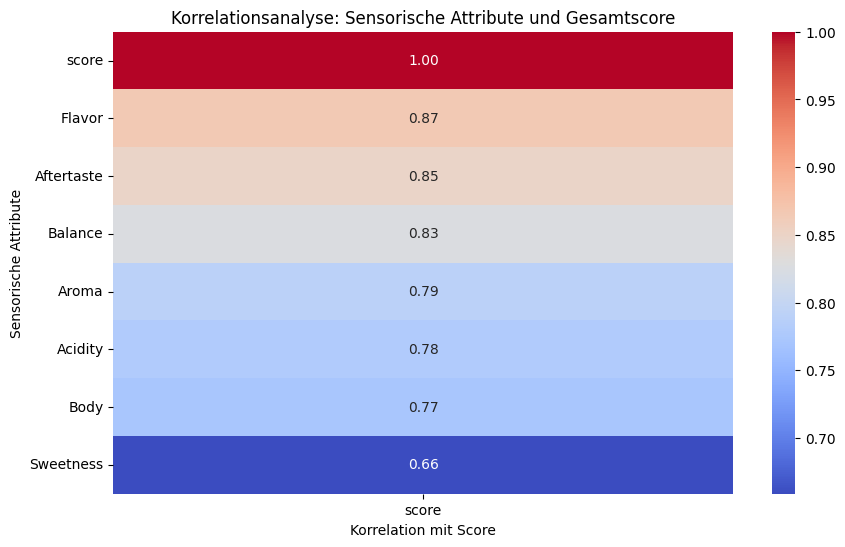

In [ ]:
# Hypothese 1
# Sensorische Attribute beeinflussen den Gesamtscore signifikant
# Arabica Dataset
sensory_features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Sweetness']
correlations = arabica_data[sensory_features + ['score']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations[['score']].sort_values(by='score', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsanalyse: Sensorische Attribute und Gesamtscore")
plt.ylabel("Sensorische Attribute")
plt.xlabel("Korrelation mit Score")
plt.show()


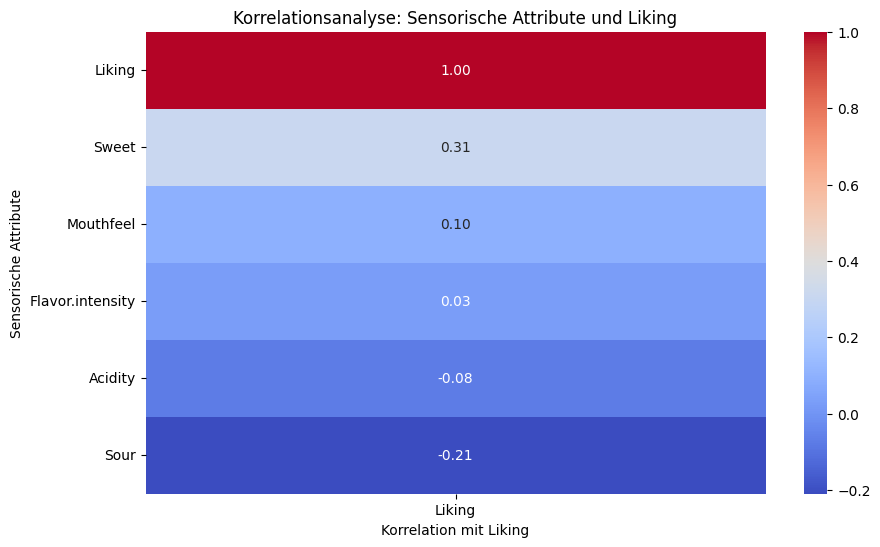

In [ ]:
# Cotter Dataset
sensory_features_cotter = ['Flavor.intensity', 'Acidity', 'Mouthfeel', 'Sweet', 'Sour']
correlations_cotter = cotter_data[sensory_features_cotter + ['Liking']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations_cotter[['Liking']].sort_values(by='Liking', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsanalyse: Sensorische Attribute und Liking")
plt.ylabel("Sensorische Attribute")
plt.xlabel("Korrelation mit Liking")
plt.show()


In [ ]:
# Hypothese 2
# Höhere Anbauhöhen sind mit besseren Kaffeebewertungen verbunden
arabica_data['altitude_group'] = pd.cut(
    arabica_data['Altitude (m)'], bins=[0, 1200, 1600, 2000, 3000], labels=['Low', 'Medium', 'High', 'Very High']
)

high_altitude_scores = arabica_data[arabica_data['altitude_group'].isin(['High', 'Very High'])]['score'].dropna()
low_altitude_scores = arabica_data[arabica_data['altitude_group'] == 'Low']['score'].dropna()

t_stat, p_value = ttest_ind(high_altitude_scores, low_altitude_scores)
print(f"T-Test: t-Statistik = {t_stat}, p-Wert = {p_value}")


T-Test: t-Statistik = 8.889114600162653, p-Wert = 6.461025441874255e-18


In [ ]:
arabica_data.head()

,score,Species,Country of Origin,Altitude (m),Variety,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Total Cup Points,Moisture (%),Color,altitude_group
0,90.58,Arabica,Ethiopia,2075.0,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,90.58,0.12,Green,Very High
1,89.92,Arabica,Ethiopia,2075.0,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92,0.12,Green,Very High
2,89.75,Arabica,Guatemala,1700.0,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,89.75,0.00,NaN,High
3,89.00,Arabica,Ethiopia,2000.0,NaN,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,89.00,0.11,Green,High
4,88.83,Arabica,Ethiopia,2075.0,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83,0.12,Green,Very High


Varianzanalyse: F-Statistik = 2.4526136125942086, p-Wert = 0.04434819999324411


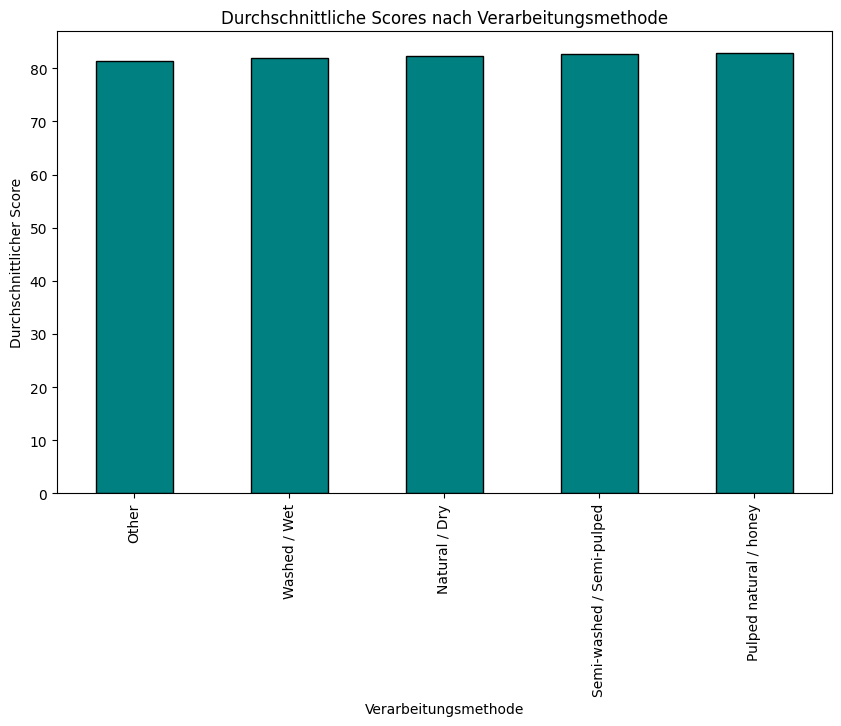

In [ ]:
# Hypothese 3
# Die Verarbeitungsmethode beeinflusst Geschmack und Score
# Varianzanalyse Arabica Dataset
processing_groups = arabica_data.groupby('Processing Method')['score'].apply(list).dropna()

f_stat, p_value = f_oneway(*processing_groups)
print(f"Varianzanalyse: F-Statistik = {f_stat}, p-Wert = {p_value}")

# Durchschnittsscore pro Verarbeitungsmethode visualisieren
processing_means = arabica_data.groupby('Processing Method')['score'].mean().sort_values()
plt.figure(figsize=(10, 6))
processing_means.plot(kind='bar', color='teal', edgecolor='black')
plt.title("Durchschnittliche Scores nach Verarbeitungsmethode")
plt.ylabel("Durchschnittlicher Score")
plt.xlabel("Verarbeitungsmethode")
plt.show()


Varianzanalyse: F-Statistik = 15.012532789302004, p-Wert = 3.678641184349871e-12


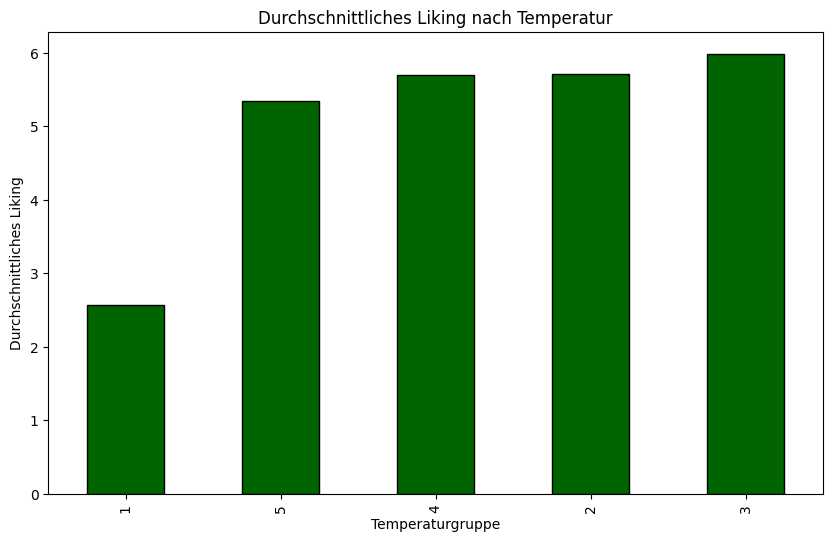

In [ ]:
# Hypothese 4
# Die Temperatur des Kaffees ist direkt mit den Liking-Bewertungen verbunden
# Cotter Dataset
# Varianzanalyse
temp_groups = cotter_data.groupby('Temp')['Liking'].apply(list).dropna()

f_stat, p_value = f_oneway(*temp_groups)
print(f"Varianzanalyse: F-Statistik = {f_stat}, p-Wert = {p_value}")

# Durchschnittliches Liking pro Temperatur visualisieren
temp_means = cotter_data.groupby('Temp')['Liking'].mean().sort_values()
plt.figure(figsize=(10, 6))
temp_means.plot(kind='bar', color='darkgreen', edgecolor='black')
plt.title("Durchschnittliches Liking nach Temperatur")
plt.ylabel("Durchschnittliches Liking")
plt.xlabel("Temperaturgruppe")
plt.show()



In [ ]:
#Speichern beider Datensätze

# Speichern des bereinigten Arabica-Datensazes
try:
    arabica_target_path = '../../data/arabica_clean.csv'
    cotter_target_path = '../../data/cotter_clean.csv'
    arabica_data.to_csv(arabica_target_path, index=False)
    cotter_data.to_csv(cotter_target_path, index=False)
    print(f"Wrote file to disk: {arabica_target_path}, {cotter_target_path}")
except Exception as e:
    print(f"Failed to save the DataFrame. Error: {e}")

Wrote file to disk: ../../data/arabica_clean.csv, ../../data/cotter_clean.csv
